In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns

#pd.options.display.float_format = '{:.2f}'.format

from model_SARIMA import find_SARIMA, build_SARIMA, SARIMA_for_all_stores, optimal_orders_10, optimal_orders_5
from model_naiv import build_naive_model, naive_for_all_stores

from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import *

from cross_validation import cv_SARIMA_all_stores, cv_naive_all_stores

warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

actual_values_dict = {}

for store in range(1, 46):
    store_df = df[df['store'] == store].copy()
    store_df.sort_values('date', inplace=True)
    store_df.set_index('date', inplace=True)

    actual_values_dict[store] = store_df['weekly_sales']

Modell wählen

In [3]:
model_type = 'SARIMA'
#model_type = 'Naive'


Alle Residuen und Fitted Values berechnen

In [4]:
fitted_values_dict = {}
residuals_dict = {}

if model_type == 'Naive':
    residuals_dict, fitted_values_dict = naive_for_all_stores('Walmart_Sales.csv')

if model_type == 'SARIMA':
    sarima_models = SARIMA_for_all_stores('Walmart_Sales.csv', whichorder = 5)
    for store in range(1, 46):
        model = sarima_models.get(store)
    
        fitted_values_dict[store] = model.fittedvalues.iloc[1:] # remove first value because it is 0
        residuals_dict[store] = model.resid.iloc[1:] # remove first value because it is 0



Store 1: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 2: Modell erstellt mit Order (4, 0, 3) und Seasonal Order (1, 0, 1, 52)
Store 3: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (2, 0, 0, 52)
Store 4: Modell erstellt mit Order (2, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 5: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 6: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 7: Modell erstellt mit Order (0, 1, 1) und Seasonal Order (0, 1, 0, 52)
Store 8: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 9: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 10: Modell erstellt mit Order (4, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 11: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 12: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 13: Modell erstellt mit Order (2, 0, 2) und Seasonal Or

Residuen

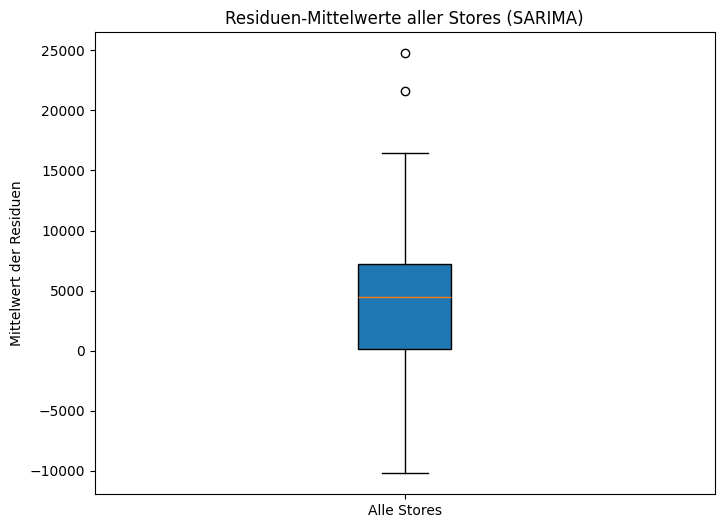

In [5]:
resid_means = []
for store in sorted(residuals_dict.keys(), key=int):
    mean_resid = residuals_dict[store].mean()
    resid_means.append(mean_resid)


# Erstelle den Boxplot der Mittelwerte
plt.figure(figsize=(8, 6))
plt.boxplot(resid_means, patch_artist=True)
plt.title('Residuen-Mittelwerte aller Stores ({})'.format(model_type))
plt.ylabel("Mittelwert der Residuen")
plt.xticks([1], ["Alle Stores"])
plt.show()

Korrelations Tests

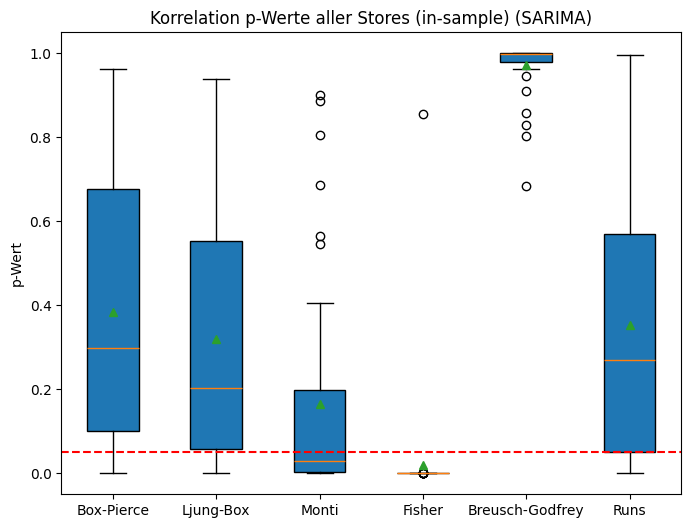

0.38482174904917416 0.32025590146862715 0.1659645243359603 0.019056783505550397 0.972630170396005 0.3524286976066869


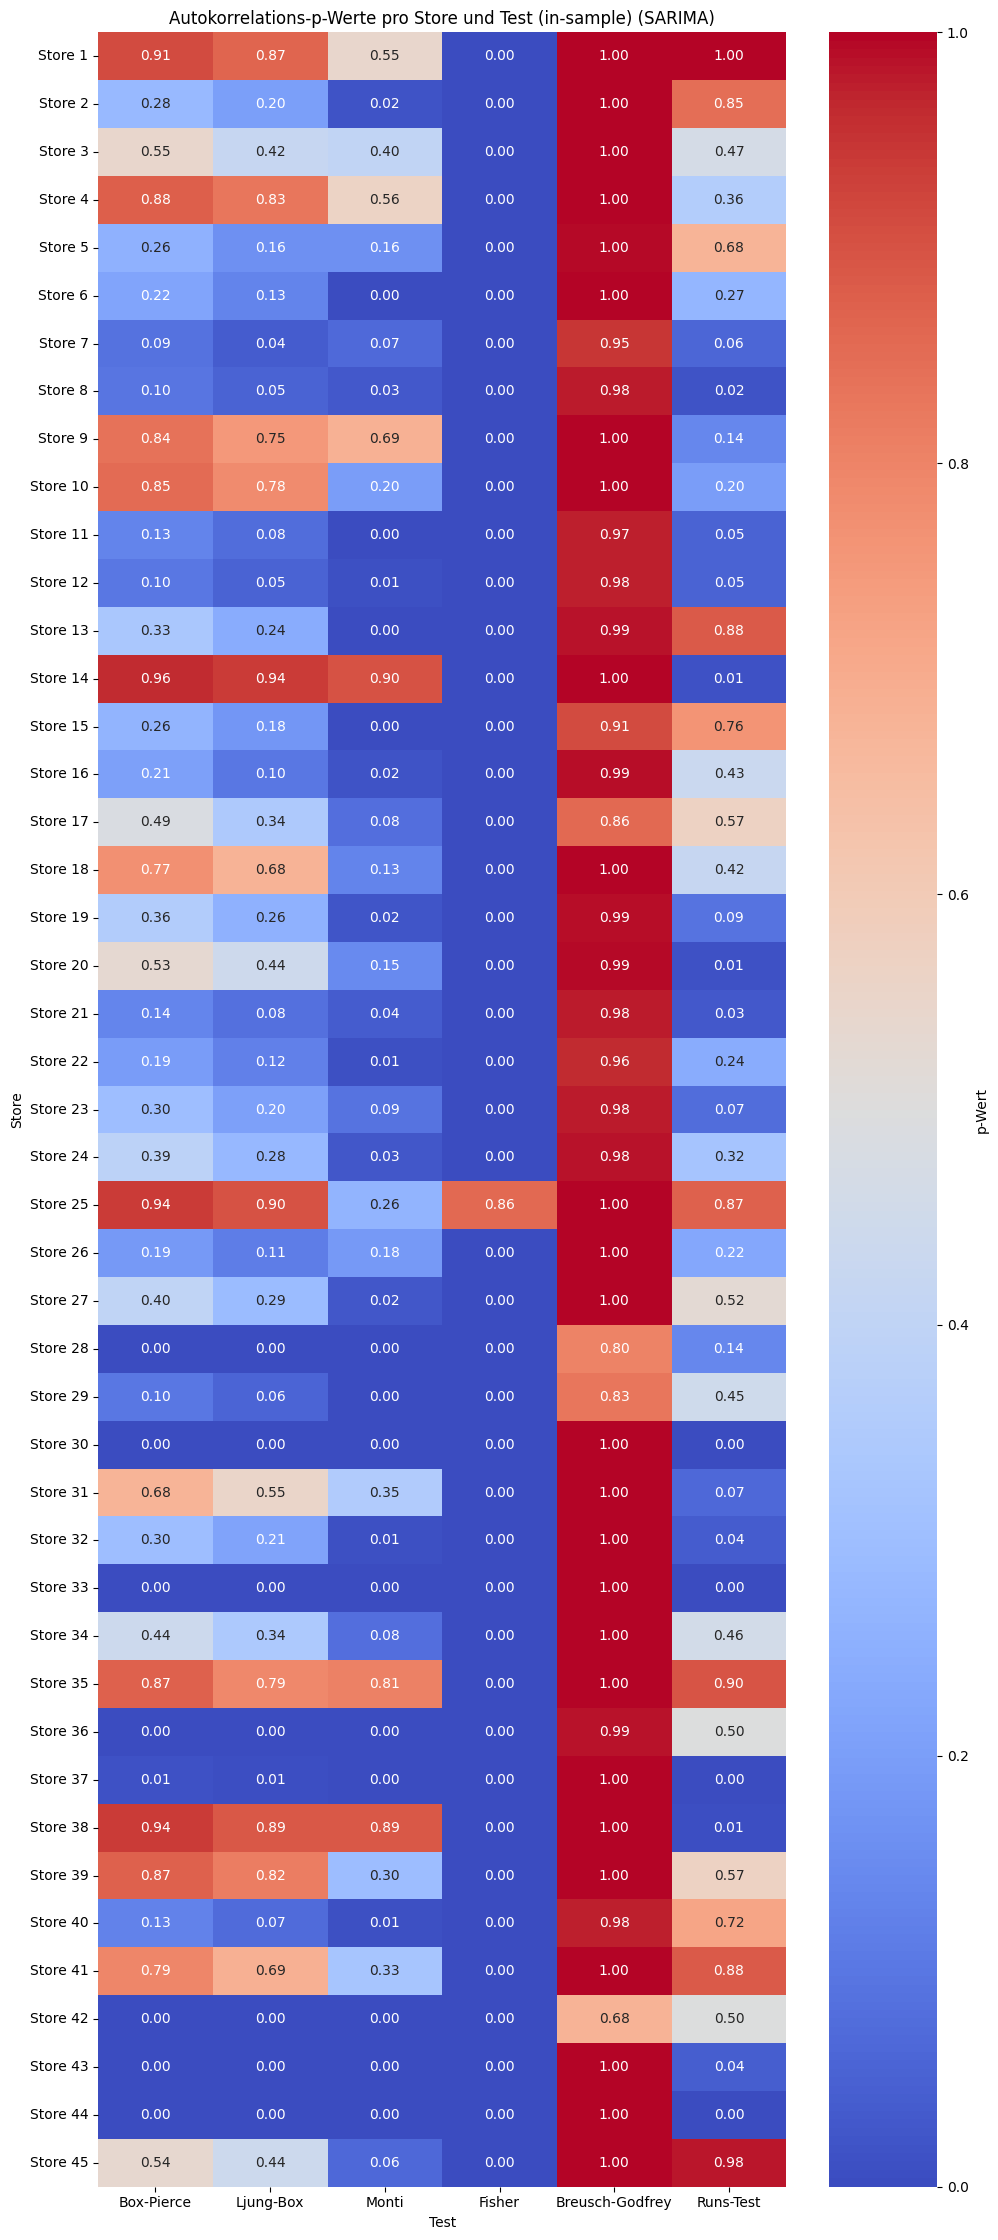

In [ ]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)

    sarima_params  = optimal_orders_5.get(str(store))
    order = tuple(sarima_params["order"])
    seasonal_order = tuple(sarima_params["seasonal_order"])

    if resid is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = resid, store_num = store, model = model_type, lags = 29, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = resid, store_num = store, model = model_type, lags=29, print_results = False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            if model_type == 'SARIMA':
                _, p_value = breusch_godfrey_test(model = sarima_models[store], lags = 29, print_results = False)
            if model_type == 'Naive':
                _, p_value = breusch_godfrey_test_naive(model = fitted_values_dict[store], lags = 29, print_results = False)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            _, p_value = monti_test(residuals = resid, store_num=store, model = model_type, m = 29, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, m = 4, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(residuals = resid, print_results = False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, bg_pvalues, rt_pvalues])

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Korrelation p-Werte aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher", "Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

print(np.mean(bp_pvalues), np.mean(lb_pvalues),  np.mean(m_pvalues), np.mean(f_pvalues), np.mean(bg_pvalues), np.mean(rt_pvalues))




# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher", "Breusch-Godfrey", "Runs-Test"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Autokorrelations-p-Werte pro Store und Test (in-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()





Durbin Watson

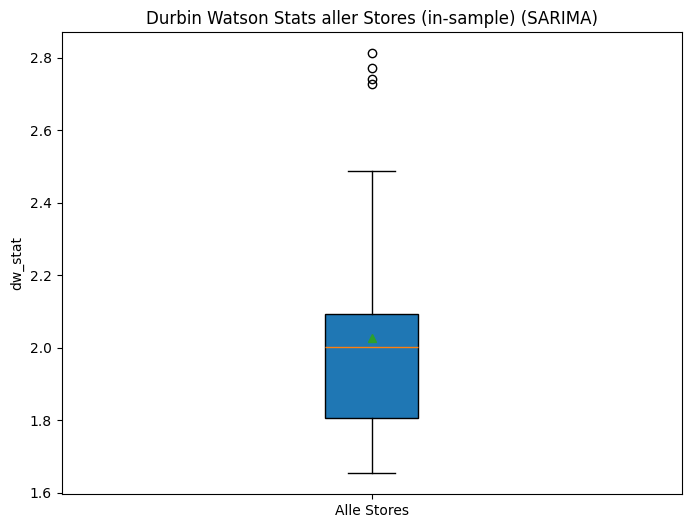

In [7]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(resid, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.show()


Mittelwert Tests

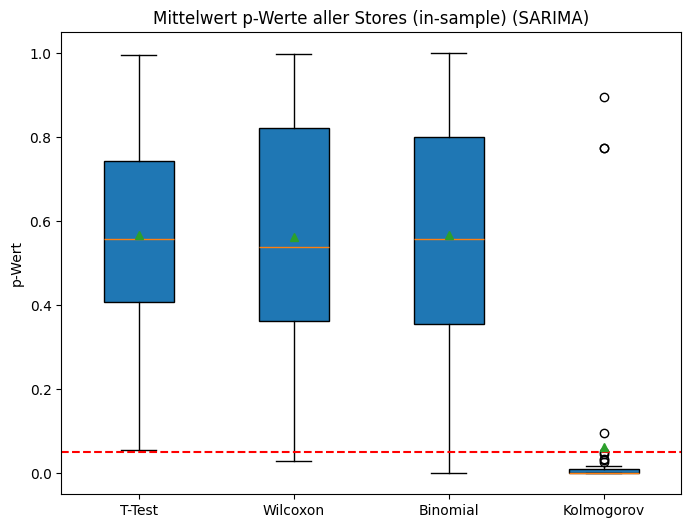

In [8]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(resid, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(resid, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(resid, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(resid, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, b_pvalues, k_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Mittelwert p-Werte aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

SMAPE

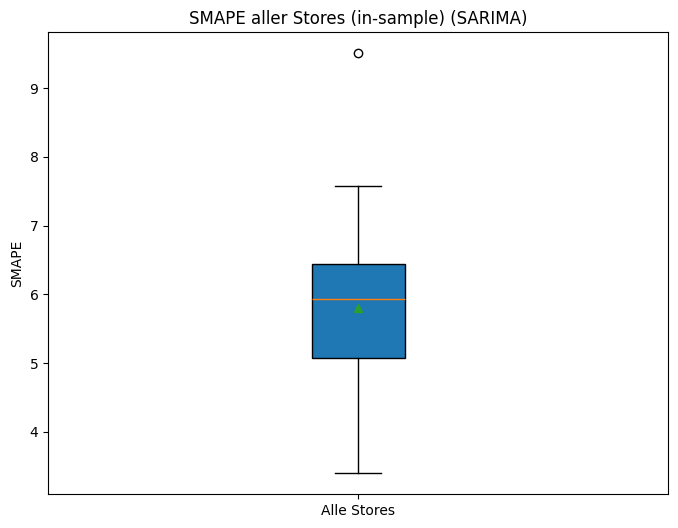

5.796271203033257


In [9]:
smape_stats = []
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()


# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    fitted_values = fitted_values_dict.get(store)

    store = df[df['store'] == store].copy()
    store.set_index('date', inplace=True)
    sales = store['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if fitted_values is not None:
        # SMAPI Test
    
        numerator = np.abs(fitted_values - sales.iloc[1:])
        denominator = (np.abs(fitted_values) + np.abs(sales.iloc[1:])) / 2
        smape = np.where(denominator == 0, 0, numerator / denominator)
        smape = np.mean(smape) * 100
        try:
            smape_stats.append(smape)
        except Exception as e:
            print(f"Fehler beim SMAPI Test für Store {store}: {e}")
            smape_stats.append(np.nan)
    else:
        smape_stats.append(np.nan)

plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title('SMAPE aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("SMAPE")
plt.xticks([1], ["Alle Stores"])
plt.show()

print(np.mean(smape_stats))

SMAPE vs. Autokorrelation p-Werte

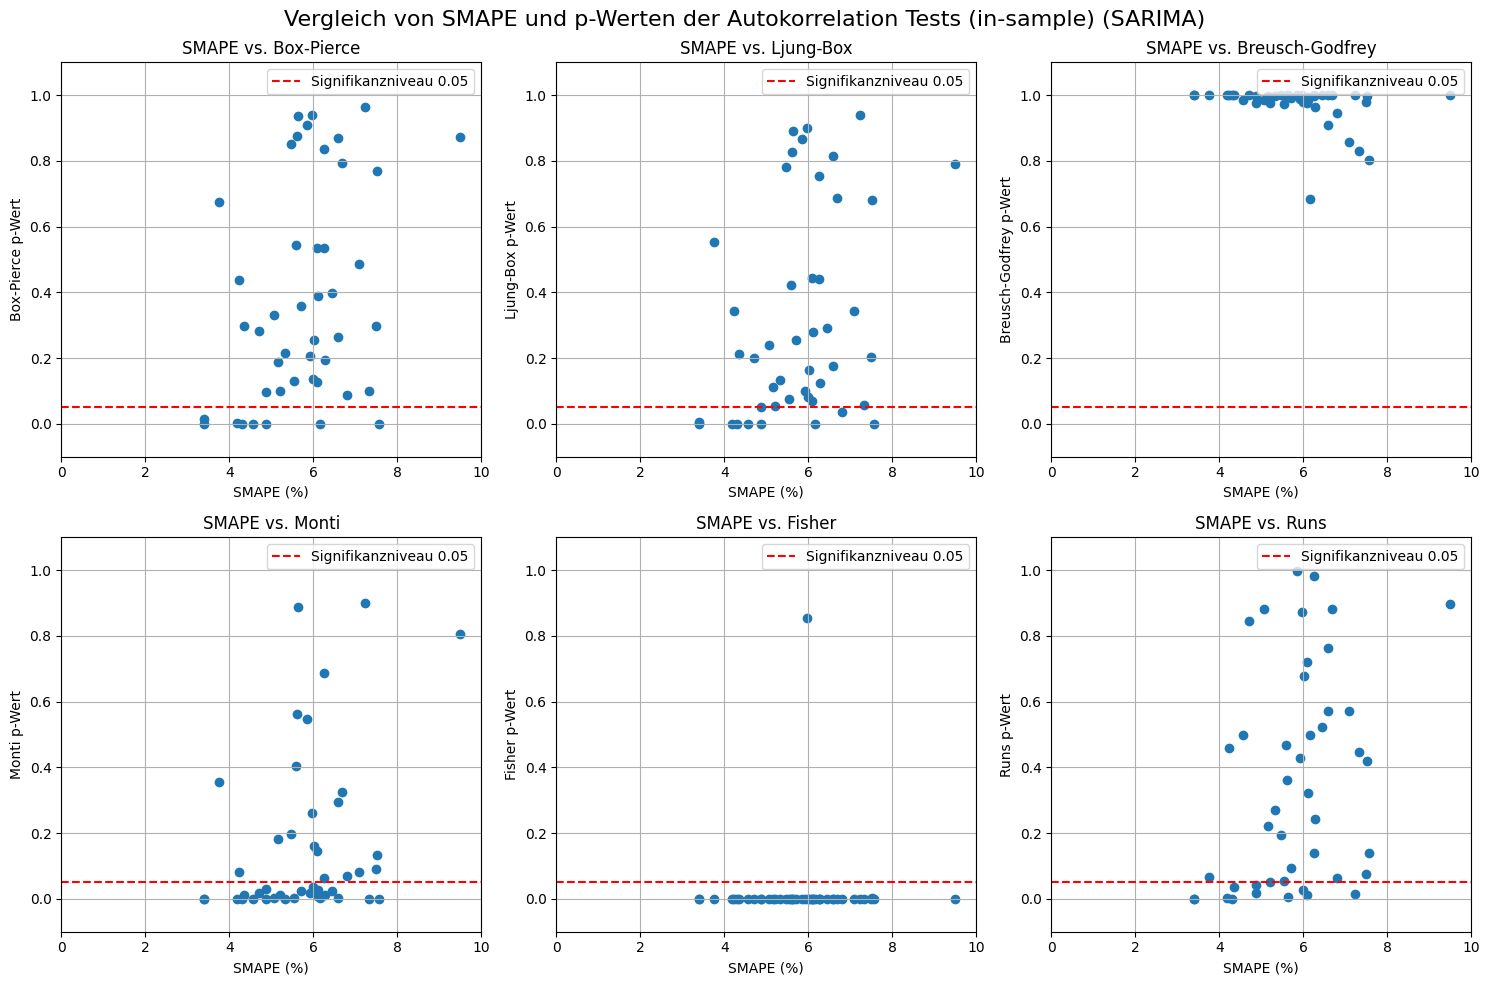

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 Zeilen, 3 Spalten


p_values_list = [bp_pvalues, lb_pvalues, bg_pvalues, m_pvalues, f_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Breusch-Godfrey", "Monti", "Fisher", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_stats, p_values_list[i])
    ax.set_xlabel('SMAPE (%)')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Autokorrelation Tests (in-sample) ({})'.format(model_type), fontsize=16)
plt.tight_layout()
plt.show()

SMAPE vs Mittelwert p-Werte

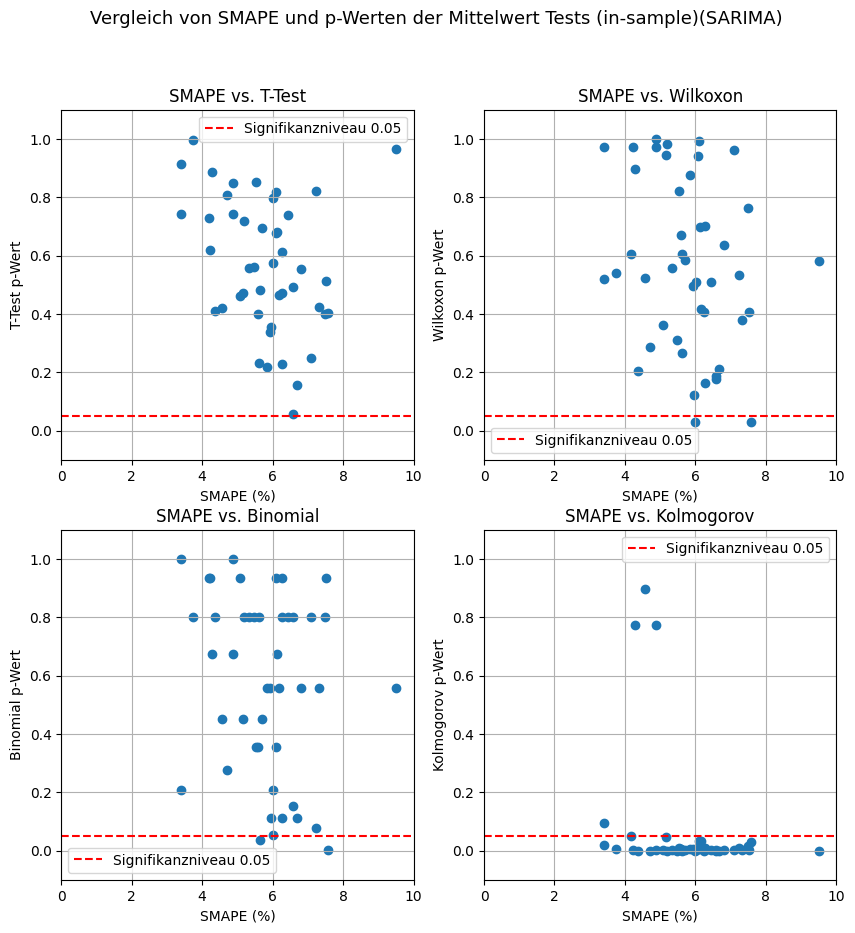

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))


p_values_list = [t_pvalues, w_pvalues, b_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Binomial", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_stats, p_values_list[i])
    ax.set_xlabel('SMAPE (%)')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (in-sample) ({})'.format(model_type), fontsize=13)
plt.show()

Kreuzvalidierung

In [12]:
if model_type == 'SARIMA':
    cvs = cv_SARIMA_all_stores('Walmart_Sales.csv', whichorder = 5)
if model_type == 'Naive':
    cvs = cv_naive_all_stores('Walmart_Sales.csv')

Verarbeite Store 1 (Datenlänge: 143)...
Cross-Validation RMSE: 88027.56322355426
Verarbeite Store 2 (Datenlänge: 143)...
Cross-Validation RMSE: 76663.40615303122
Verarbeite Store 3 (Datenlänge: 143)...


KeyboardInterrupt: 

Korrelations Test

Fehler beim Breusch-Godfrey Test für Store 1: name 'sarima_models' is not defined
Fehler beim Breusch-Godfrey Test für Store 2: name 'sarima_models' is not defined
Fehler beim Breusch-Godfrey Test für Store 3: name 'sarima_models' is not defined
Fehler beim Breusch-Godfrey Test für Store 4: name 'sarima_models' is not defined
Fehler beim Breusch-Godfrey Test für Store 5: name 'sarima_models' is not defined
Fehler beim Breusch-Godfrey Test für Store 6: name 'sarima_models' is not defined
Fehler beim Breusch-Godfrey Test für Store 7: name 'sarima_models' is not defined
Fehler beim Breusch-Godfrey Test für Store 8: name 'sarima_models' is not defined
Fehler beim Breusch-Godfrey Test für Store 9: name 'sarima_models' is not defined
Fehler beim Breusch-Godfrey Test für Store 10: name 'sarima_models' is not defined
Fehler beim Breusch-Godfrey Test für Store 11: name 'sarima_models' is not defined
Fehler beim Breusch-Godfrey Test für Store 12: name 'sarima_models' is not defined
Fehler beim B

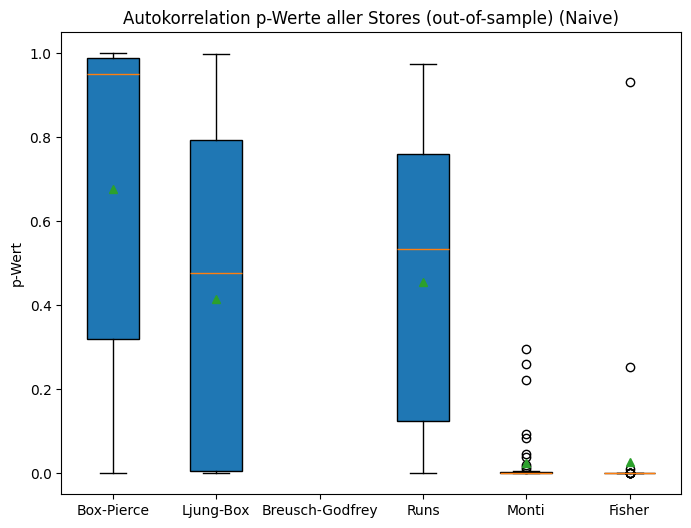

In [ ]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = cvs[cvs['store'] == store]['error']
    if errors is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = errors, store_num = store, model = model_type, lags = 29, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = errors, store_num = store, model = model_type, lags = 29, print_results=False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_test(model = sarima_models[store], lags = 29, print_results = False) #TODO: gleiches modell wie in-sample?
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = monti_test(residuals = errors, store_num = store, model = model_type, m = 20, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, m = 4, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(residuals = errors, print_results=False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, bg_pvalues, rt_pvalues, m_pvalues, f_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Autokorrelation p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6], ["Box-Pierce", "Ljung-Box", "Breusch-Godfrey", "Runs", "Monti", "Fisher"])
plt.show()



Durbin Watson

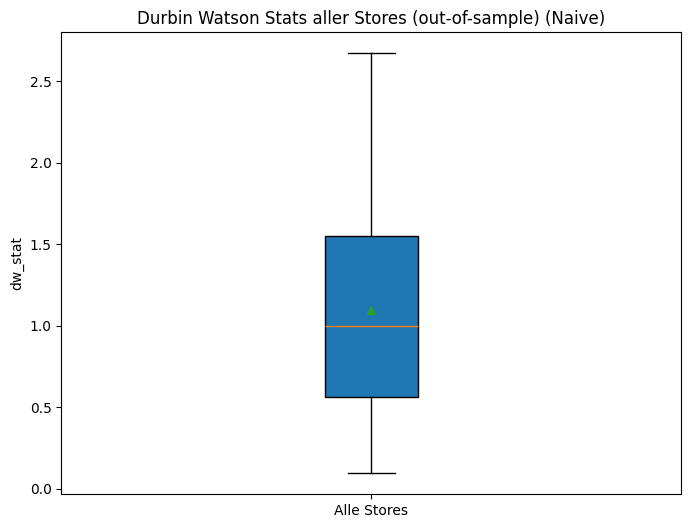

In [ ]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    error = cvs[cvs['store'] == store]['error']
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(error, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.show()


Mittelwert Tests

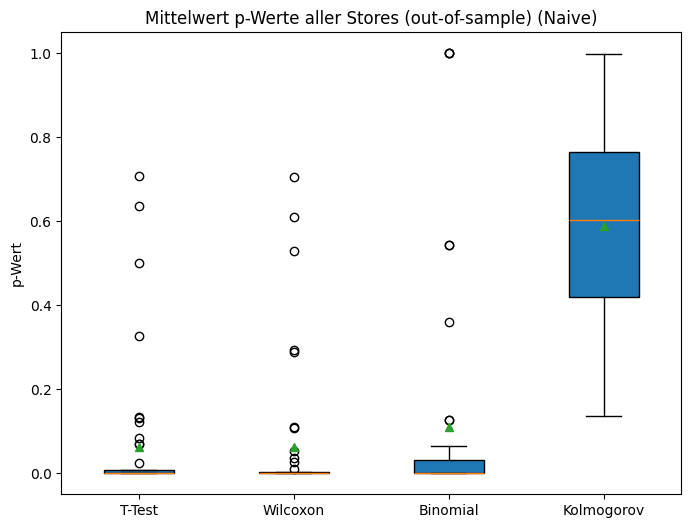

In [ ]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = cvs[cvs['store'] == store]['error']
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(errors, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(errors, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(errors, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(errors, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, b_pvalues, k_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Mittelwert p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov"])
plt.show()



SMAPE

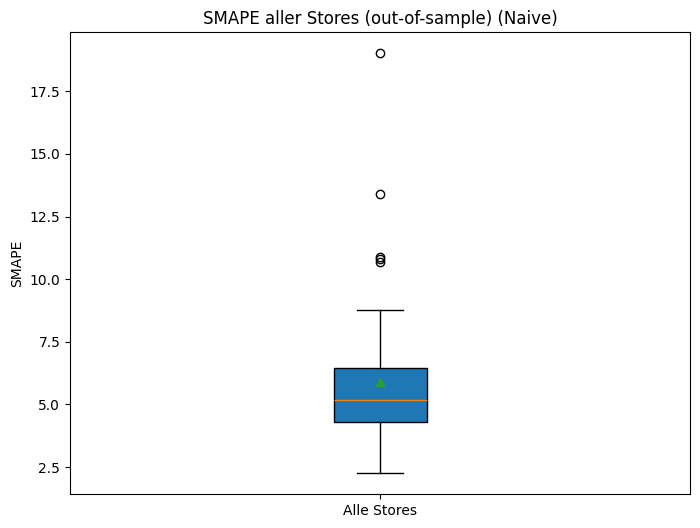

5.912367842549262


In [ ]:
smape_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    forecast_values = cvs[cvs['store'] == store]['forecast']
    actual_values = cvs[cvs['store'] == store]['actual']

    if len(forecast_values) > 0:
        # SMAPI Test
    
        numerator = np.abs(forecast_values - actual_values)
        denominator = (np.abs(forecast_values) + np.abs(actual_values)) / 2
        smape = np.where(denominator == 0, 0, numerator / denominator)
        smape = np.mean(smape) * 100
        try:
            smape_stats.append(smape)
        except Exception as e:
            print(f"Fehler beim SMAPI Test für Store {store}: {e}")
            smape_stats.append(np.nan)
    else:
        smape_stats.append(np.nan)

plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title('SMAPE aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("SMAPE")
plt.xticks([1], ["Alle Stores"])
plt.show()

print(np.mean(smape_stats))

SMAPE vs. Autokorrelation p-Werte

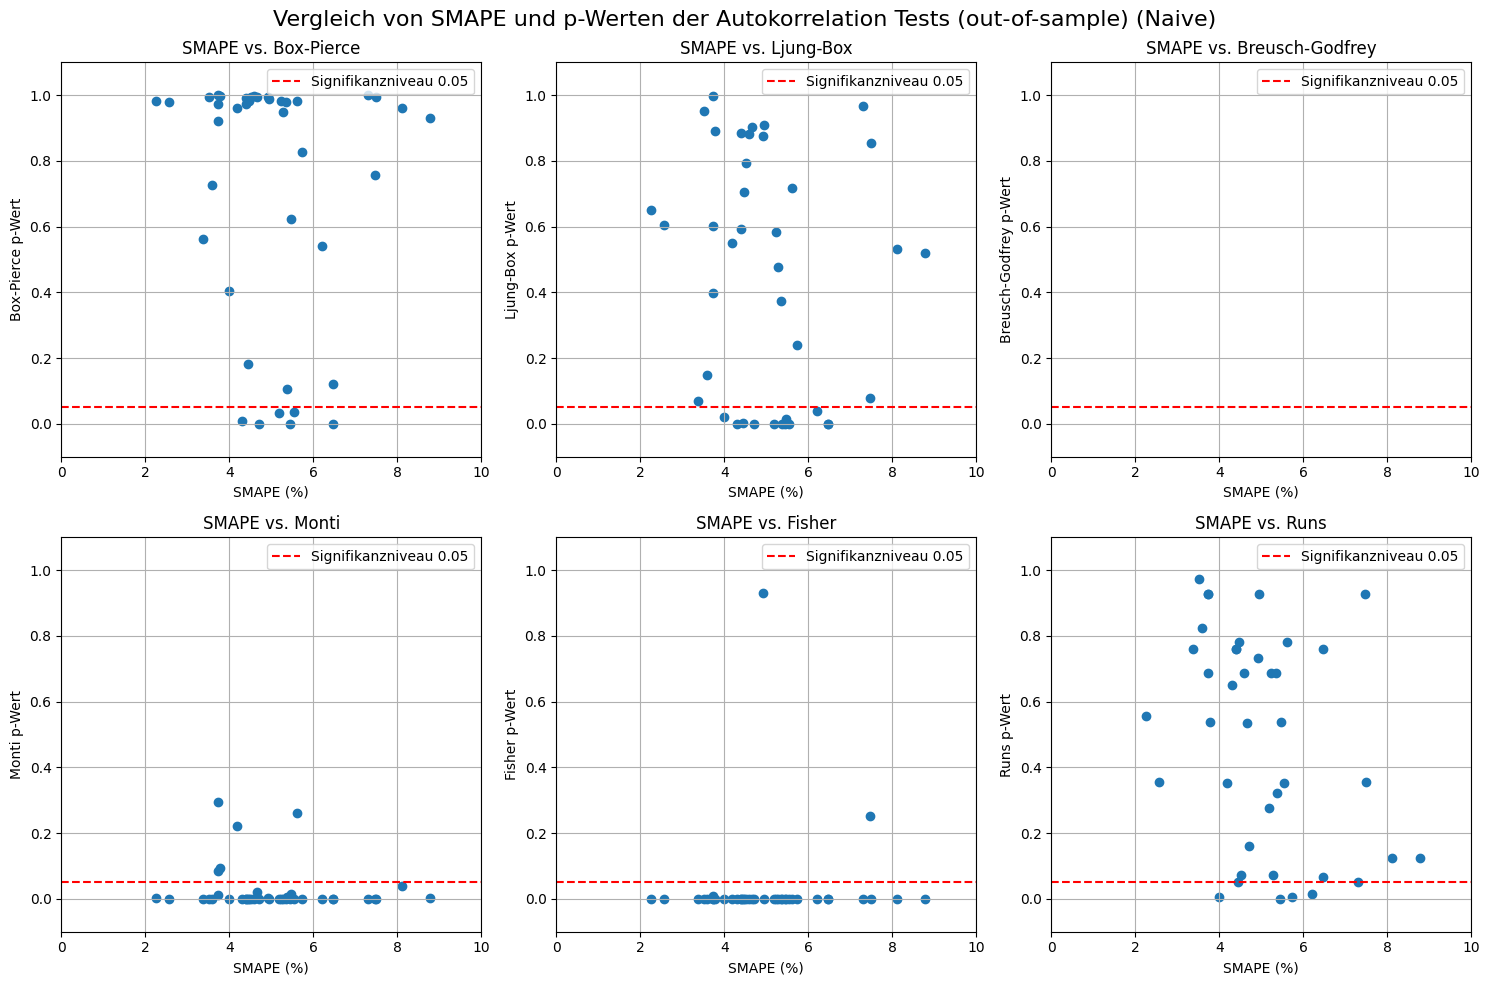

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 Zeilen, 3 Spalten


p_values_list = [bp_pvalues, lb_pvalues, bg_pvalues, m_pvalues, f_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Breusch-Godfrey", "Monti", "Fisher", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_stats, p_values_list[i])
    ax.set_xlabel('SMAPE (%)')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Autokorrelation Tests (out-of-sample) ({})'.format(model_type), fontsize=16)
plt.tight_layout()
plt.show()

SMAPE vs. Mittelwert p-Werte

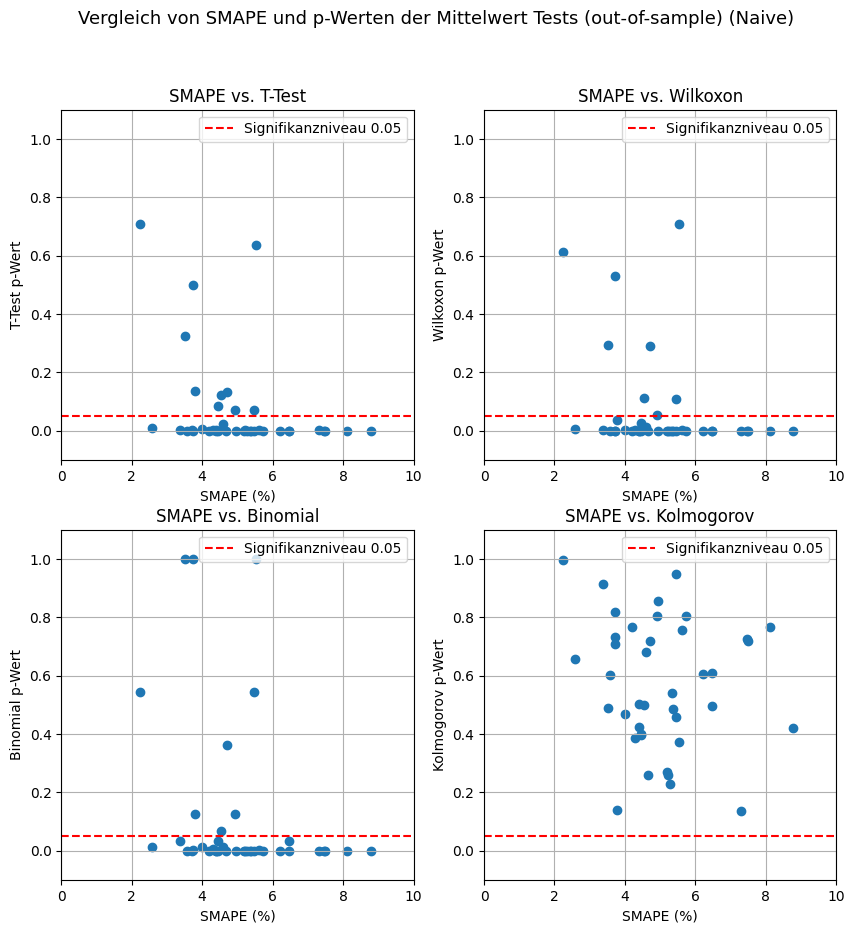

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))


p_values_list = [t_pvalues, w_pvalues, b_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Binomial", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_stats, p_values_list[i])
    ax.set_xlabel('SMAPE (%)')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (out-of-sample) ({})'.format(model_type), fontsize=13)
plt.show()